In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2

In [2]:
import torchvision.transforms as transforms

In [3]:
pts=np.random.multivariate_normal([0, 0], [[1,1/2],[1/2,1]],size=10000)

In [4]:
pts[:,0]

array([ 0.83677148, -0.33655721,  0.3615271 , ..., -1.12139734,
       -0.49179764,  0.72866002])

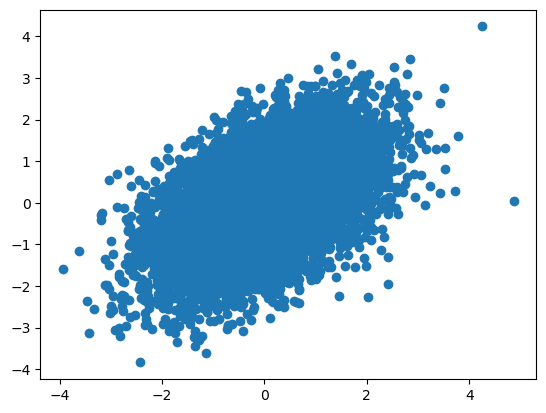

In [5]:
plt.scatter(pts[:,0],pts[:,1])

In [6]:
# original dataset x0
x0=image=cv2.imread("E:/nSm/tempMatchAlgo/BBS/data/images/box.png")

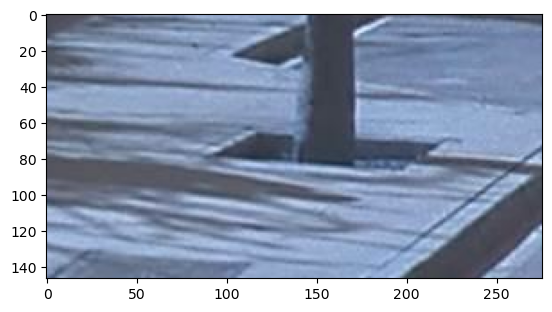

In [7]:
%matplotlib inline
plt.imshow(image)

In [8]:
iterations=50
beta=np.random.normal(0,1,iterations)
alpha=1-beta
alphaT=[alpha[0]]
for i in range(1,alpha.shape[0]):
    alphaT.append(alphaT[-1]*alpha[i])
alphaT=np.array(alphaT)

In [9]:
transformerImgToTensor=transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda t:(t*2-1))
])

transformerTensorToImg=transforms.Compose([
    transforms.Lambda(lambda t:(t+1)/2),
    transforms.Lambda(lambda t:t.permute(1,2,0)),
    transforms.Lambda(lambda t:t*255),
    transforms.Lambda(lambda t:t.numpy().astype('uint8'))
])


In [10]:
image=transformerImgToTensor(image)
# image=transformerTensorToImg(image)

In [11]:
t= torch.tensor([0,1,2,5])

In [12]:
def forwardDiffusion(x0,t,betas=torch.linspace(0,1/4,7)):
    noise=torch.randn_like(x0)
    alphas=1-betas
    alphasHat=torch.cumprod(alphas,axis=0)
    pars=torch.gather(alphasHat,-1,t).reshape(-1,1,1,1)
    return torch.sqrt(pars)*x0+torch.sqrt(1-pars)*noise
# forwardDiffusion(image,t).shape

In [13]:
imageNoised=forwardDiffusion(image,t)

Text(0.5, 1.0, 'indice : 1')

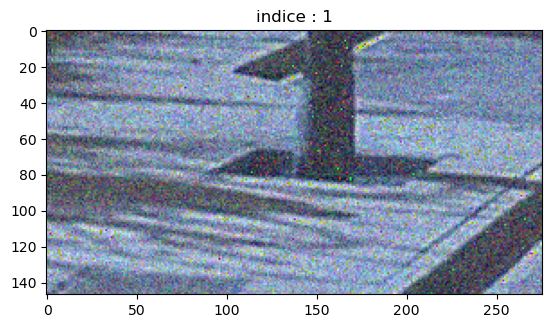

In [14]:
indice=1
plt.imshow(transformerTensorToImg(imageNoised[indice]))
plt.title("indice : {}".format(indice))

In [15]:
#implementing unet

In [16]:
import torch.nn as nn

In [17]:
##upper Convolution
def cropImg(tensor,targetTensor):
        targetW,targetH=targetTensor.shape[2:]
        w,h=tensor.shape[2:]
        deltaW,deltaH=w-targetW,h-targetH
        return tensor[:,:,deltaW:w,deltaH:h]

class DoubleConv(nn.Module):
    def __init__(self,inChannels,outChannels):
        super().__init__()
        self.convSeq=nn.Sequential(
        nn.Conv2d(inChannels,outChannels,kernel_size=3,padding=1),#,padding=1
        nn.ReLU(inplace=True),
        nn.Conv2d(outChannels,outChannels,kernel_size=3,padding=1),#,padding=1
        nn.ReLU(inplace=True))
        
    def forward(self,x):
        return self.convSeq(x)

class DownSample(nn.Module):
    def __init__(self,inChannels,outChannels):
        super().__init__()
        self.doubleConv=DoubleConv(inChannels,outChannels)
        self.maxPool=nn.MaxPool2d(kernel_size=2,stride=2)
    def forward(self,x):
        double=self.doubleConv(x)
        down=self.maxPool(double)
        return double,down
    
class UpSample(nn.Module):
    def __init__(self,inChannels,outChannels):
        super().__init__()
        self.upConv=nn.ConvTranspose2d(inChannels,inChannels//2,kernel_size=2,stride=2)
        self.doubleConv=DoubleConv(inChannels,outChannels)
    def forward(self,x1,x2):
        x1=self.upConv(x1) #inChannels//2
        x2=cropImg(x2,x1)
        print("c",x1.shape,x2.shape)
        x=torch.cat([x1,x2],1)
        double=self.doubleConv(x)
        return double
        
class Unet(nn.Module):
    def __init__(self,inChannels,numClasses):
        super().__init__()
#         encoder
        self.down1=DownSample(inChannels,64)
        self.down2=DownSample(64,128)
        self.down3=DownSample(128,256)
        self.down4=DownSample(256,512)
#         bottle neck | edge
        self.down5=DoubleConv(512,1024)
#         decoder
        self.upper1=UpSample(1024,512)
        self.upper2=UpSample(512,256)
        self.upper3=UpSample(256,128)
        self.upper4=UpSample(128,64)
#        out
        self.upper5=nn.ConvTranspose2d(64,numClasses,kernel_size=1,stride=2)
    def forward(self,x):
#         encoder
        print(x.shape)
        double1,downE1=self.down1(x)
        print(double1.shape)
        double2,downE2=self.down2(downE1)
        print(double2.shape)
        double3,downE3=self.down3(downE2)
        print(double3.shape)
        double4,downE4=self.down4(downE3)
        print(double4.shape)
#         bottle neck
        double5=self.down5(downE4) #1024
        print(double5.shape)
#         decoder
        upperE1=self.upper1(double5,double4)#512  64
        upperE2=self.upper2(upperE1,double3)
        upperE3=self.upper3(upperE2,double2)
        upperE4=self.upper4(upperE3,double1)
#         out
        out=self.upper5(upperE4)
        
        return out
    
        

In [18]:
im1=imageNoised[0][None,:,:,:]
im2=torch.rand(1,3,512,512)
unet=Unet(3,10)
im=unet(im1)

torch.Size([1, 3, 147, 276])
torch.Size([1, 64, 147, 276])
torch.Size([1, 128, 73, 138])
torch.Size([1, 256, 36, 69])
torch.Size([1, 512, 18, 34])
torch.Size([1, 1024, 9, 17])
c torch.Size([1, 512, 18, 34]) torch.Size([1, 512, 18, 34])
c torch.Size([1, 256, 36, 68]) torch.Size([1, 256, 36, 68])
c torch.Size([1, 128, 72, 136]) torch.Size([1, 128, 72, 136])
c torch.Size([1, 64, 144, 272]) torch.Size([1, 64, 144, 272])


In [21]:
im[0]

tensor([[[ 0.1423,  0.0934,  0.1414,  ...,  0.1412,  0.0934,  0.1431],
         [ 0.0934,  0.0934,  0.0934,  ...,  0.0934,  0.0934,  0.0934],
         [ 0.1443,  0.0934,  0.1399,  ...,  0.1345,  0.0934,  0.1426],
         ...,
         [ 0.1440,  0.0934,  0.1368,  ...,  0.1415,  0.0934,  0.1414],
         [ 0.0934,  0.0934,  0.0934,  ...,  0.0934,  0.0934,  0.0934],
         [ 0.1428,  0.0934,  0.1447,  ...,  0.1512,  0.0934,  0.1449]],

        [[-0.2692, -0.2619, -0.2706,  ..., -0.2626, -0.2619, -0.2578],
         [-0.2619, -0.2619, -0.2619,  ..., -0.2619, -0.2619, -0.2619],
         [-0.2661, -0.2619, -0.2657,  ..., -0.2590, -0.2619, -0.2561],
         ...,
         [-0.2643, -0.2619, -0.2686,  ..., -0.2539, -0.2619, -0.2604],
         [-0.2619, -0.2619, -0.2619,  ..., -0.2619, -0.2619, -0.2619],
         [-0.2574, -0.2619, -0.2538,  ..., -0.2465, -0.2619, -0.2604]],

        [[ 0.1727,  0.1568,  0.1715,  ...,  0.1640,  0.1568,  0.1760],
         [ 0.1568,  0.1568,  0.1568,  ...,  0

In [19]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [21]:
from skimage.segmentation import slic,watershed,mark_boundaries
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import sobel

In [137]:
toBeSegmented=io.imread("E:/nSm/tempMatchAlgo/BBS/data/images/box.png")
# segments_=slic(toBeSegmented, n_segments=250, compactness=10, sigma=1, start_label=1)
segments_= watershed(sobel(rgb2gray(toBeSegmented)), markers=50, compactness=0.001)

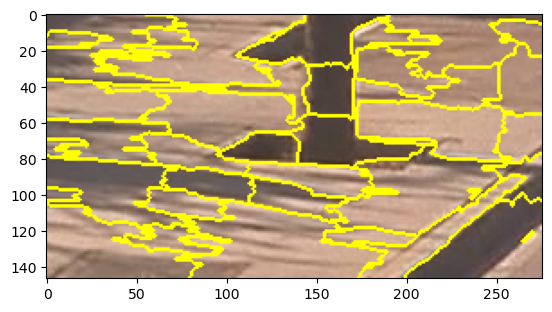

In [138]:
%matplotlib inline
plt.imshow(mark_boundaries(toBeSegmented,segments_))

In [81]:
toBeSegmented.max()

255.0

In [211]:
image=cv2.imread("E:/nSm/tempMatchAlgo/BBS/data/images/box.png")
temp=cv2.imread("E:/nSm/tempMatchAlgo/BBS/data/templates/temp.png")

In [151]:
import keras
import tensorflow as tf
from keras import Model
from keras.layers import Lambda,Concatenate,Layer
import tensorflow.keras.backend as K
from keras.applications.vgg16 import preprocess_input

In [152]:
vgg19 = keras.applications.vgg19.VGG19( include_top = False, weights = 'imagenet' )

In [212]:
input_ = vgg19.input
conv1_2 = vgg19.get_layer('block1_conv2').output
conv3_4 = vgg19.get_layer('block3_conv4').output
conv3_4 = Lambda( lambda x: tf.compat.v1.image.resize_bilinear( x[0], size=(tf.shape(x[1])[1], tf.shape(x[1])[2]), align_corners=True), name='resized_image' )( [conv3_4, conv1_2] )
concat = Concatenate()( [conv1_2, conv3_4] )
featex = Model( [input_], [concat], name='featex' )

In [213]:
# features 
imageF1=featex(np.expand_dims(preprocess_input(image),axis=0))
tempF1=featex(np.expand_dims(preprocess_input(temp),axis=0))

In [214]:
imageF1,tempF1=NormalisationLayer(name='norm_layer' )([imageF1,tempF1])

In [215]:
imageF1.shape

TensorShape([1, 147, 276, 320])

In [216]:
dist=lambda x: tf.einsum('xabc,xdec->xabde',K.l2_normalize(x[0],axis=1),K.l2_normalize(x[1], axis=-1),name="cosine_dist")

In [217]:
imageF1.shape,tempF1.shape

(TensorShape([1, 147, 276, 320]), TensorShape([1, 99, 120, 320]))

In [205]:
dist([imageF1,tempF1]).shape

TensorShape([1, 117, 219, 99, 120])

In [79]:
#  Keras does not automatically infer multiple input tensors for custom layers. 
# In your custom layer, you need to override the build method to properly handle multiple input tensors.
class NormalisationLayer(Layer):
    def __init__(self,**kwargs):
        super(NormalisationLayer,self).__init__(**kwargs)
    def build(self,x):
        super(NormalisationLayer,self).build(x)
    def call(self,x):
        x1,x2=x
        bs, H, W, _ = [tf.shape(x1)[i] for i in range(4)]
        _, h, w, _ = [tf.shape(x2)[i] for i in range(4)]
        x1 = tf.reshape(x1, ( bs, H*W, -1 ) )
        x2 = tf.reshape(x2, ( bs, h*w, -1 ) )
        concat = tf.concat([x1, x2], axis=1)
        x_mean = K.mean( concat, axis=1, keepdims=True )
        x_std = K.std( concat, axis=1, keepdims = True )
        x1 = (x1 - x_mean) / x_std
        x2 = (x2 - x_mean) / x_std
        x1 = tf.reshape(x1, ( bs, H, W, -1 ) )
        x2 = tf.reshape(x2, ( bs, h, w, -1 ) )
        return [x1, x2]

In [207]:
class QATM(Layer):
    def __init__(self,alpha=1,**kwargs):
        self.alpha=alpha
        super(QATM,self).__init__(**kwargs)
    
    def build(self,input_shape):
        self.coef_ref = self.add_weight(shape=(1,),
                                    initializer=keras.initializers.Constant(self.alpha),
                                    name='softmax_coef_ref',)
        self.coef_qry = self.add_weight(shape=(1,),
                                    initializer=keras.initializers.Constant(self.alpha),
                                    name='softmax_coef_qry',)
        super(QATM,self).build(input_shape)
    
    def call(self,x):
        batch_size, ref_row, ref_col, qry_row, qry_col = [ tf.shape(x)[k] for k in range(5) ]
        x=tf.reshape(x,[batch_size,ref_row*ref_col,qry_row*qry_col])
#         best match

#       difference to the max value 0 for the best value and negative for everything else
        x_ref=x-K.max(x,axis=1,keepdims=True)
        x_qry=x-K.max(x,axis=2,keepdims=True)
        
        conf_ref = tf.nn.softmax( self.coef_ref*x_ref, axis=1 )
        conf_qry = tf.nn.softmax( self.coef_ref*x_qry, axis=2)
        
        confidence = K.sqrt(conf_ref * conf_qry )
        
        ind1,ind2 = tf.meshgrid( tf.range(batch_size),tf.range(ref_row*ref_col), indexing='ij' )
        
        
        values,indices=tf.nn.top_k(confidence,k=1)
        
#         print("gggg")
#         ind1 = K.flatten( ind1 )
#         ind2 = K.flatten( ind2 )
#         indices = K.flatten( indices )
#         indices = K.stack([ind1,ind2,indices],axis=1)
#         values = tf.gather_nd( confidence, indices )
#         values = tf.reshape( values, [batch_size, ref_row, ref_col, 1])
        
#         tf.gather_nd
        values=K.flatten(values)
        values=tf.reshape(values,[batch_size, ref_row, ref_col, 1])
        return values
    def compute_output_shape( self, input_shape ):
        bs, H, W, _, _ = input_shape
        return (bs, H, W, 1)


In [200]:
# tests on shapes ....
x = tf.convert_to_tensor([[[1, 6, 8], [1, 5, 2]]])
x=tf.cast(x,tf.float32)
# tf.nn.softmax(x,axis=1).shape,x.shape
values,indices=tf.nn.top_k(x,k=1)
x.shape,indices.shape,values

ind1, ind2 = tf.meshgrid( tf.range(1), 
                          tf.range(2), indexing='ij' )
ind1 = K.flatten( ind1 )
ind2 = K.flatten( ind2 )

ind1,ind2
indices = K.flatten( indices )
indices
ind3 = K.stack([ind1,ind2,indices],axis=1)
ind3

tf.gather_nd(x,ind3),
j=K.flatten(values)
tf.reshape(j, [1,1,2,1])

<tf.Tensor: shape=(1, 1, 2, 1), dtype=float32, numpy=
array([[[[8.],
         [5.]]]], dtype=float32)>

In [188]:
tf.range(2)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([0, 1])>

<tf.Tensor: shape=(1, 144, 426, 1), dtype=float32, numpy=
array([[[[1.29334396e-04],
         [1.45138212e-04],
         [1.70025392e-04],
         ...,
         [9.90369663e-05],
         [9.65355357e-05],
         [9.22989493e-05]],

        [[1.16885458e-04],
         [1.16394134e-04],
         [1.30851709e-04],
         ...,
         [8.49997668e-05],
         [8.49445714e-05],
         [8.50939759e-05]],

        [[1.14845563e-04],
         [1.14861898e-04],
         [1.13036513e-04],
         ...,
         [7.90571576e-05],
         [8.03620278e-05],
         [8.27593467e-05]],

        ...,

        [[1.41232958e-04],
         [1.43002981e-04],
         [1.41121389e-04],
         ...,
         [9.17675570e-05],
         [9.42188999e-05],
         [9.59137469e-05]],

        [[1.38867312e-04],
         [1.59426359e-04],
         [1.78368515e-04],
         ...,
         [1.03832572e-04],
         [1.02990081e-04],
         [1.04803148e-04]],

        [[1.61060467e-04],
         [1

In [82]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[]


In [93]:
x=dist([imageF1,tempF1])
coef_ref=10
batch_size, ref_row, ref_col, qry_row, qry_col = [ tf.shape(x)[k] for k in range(5) ]
x=tf.reshape(x,[batch_size,ref_row*ref_col,qry_row*qry_col])
#         best match

#       difference to the max value 0 for the best value and negative for everything else
x_ref=x-K.max(x,axis=1,keepdims=True)
x_qry=x-K.max(x,axis=2,keepdims=True)

print('jjj')
conf_ref = tf.nn.softmax( coef_ref*x_ref, axis=1 )
print('lll')
conf_qry = tf.nn.softmax( coef_ref*x_qry, axis=1 )

confidence = K.sqrt(conf_ref * conf_qry )

ind1,ind2 = tf.meshgrid( tf.range(batch_size),tf.range(ref_row*ref_col), indexing='ij' )


values,indices=tf.nn.top_k(confidence,k=1)

print("gggg")
ind1 = K.flatten( ind1 )
ind2 = K.flatten( ind2 )
indices = K.flatten( indices )
indices = K.stack([ind1,ind2,indices],axis=1)
values = tf.gather_nd( confidence, indices )
values = tf.reshape( values, [batch_size, ref_row, ref_col, 1])

#         tf.gather_nd
#         values=K.flatten(values)
#         values=tf.reshape(values,[batch_size, ref_row, ref_col, 1])

jjj
lll
gggg


In [25]:
tf.__version__

'2.10.1'

In [41]:
from scipy.ndimage.filters import convolve
import math
def compute_score( x, w, h ):
    # score of response strength
    k = np.ones( (h, w) )
    score = convolve( x, k, mode='wrap' )
    score[:,:w//2] = 0
    score[:, math.ceil(-w/2):] = 0
    score[:h//2, :] = 0
    score[math.ceil(-h/2):, :] = 0
    return score

C:\Users\yasmine\AppData\Local\Temp\ipykernel_34624\1968140060.py:1: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import convolve


In [218]:
alpha=1.0
conf_map=QATM(alpha,name='qatm')(dist([imageF1,tempF1]))

In [219]:
val=np.log(conf_map)
gray = val[0,:,:,0]
gray = cv2.resize( gray, (image.shape[1], image.shape[0]) )
w,h=temp.shape[1],temp.shape[0]
score = compute_score(gray,w,h) 
score[score>-1e-7] = score.min()
score = np.exp(score / (h*w))
row = np.argmax( np.max(score, axis=1) )
col = np.argmax( np.max(score, axis=0) )
x = col - 1. * w / 2
y = row - 1. * h / 2

In [107]:
x,y

(241.0, 0.0)

In [63]:
score.shape,image.shape

((147, 276), (147, 276, 3))

In [48]:
temp.shape

(99, 99, 3)

In [62]:
math.ceil(-w/2)

-49

In [66]:
k = np.ones( (h, w) )
x = gray.copy()
l=convolve( x, k, mode='wrap' )
l.shape

(147, 276)

In [131]:
row,col

(15, 133)

<IPython.core.display.Javascript object>


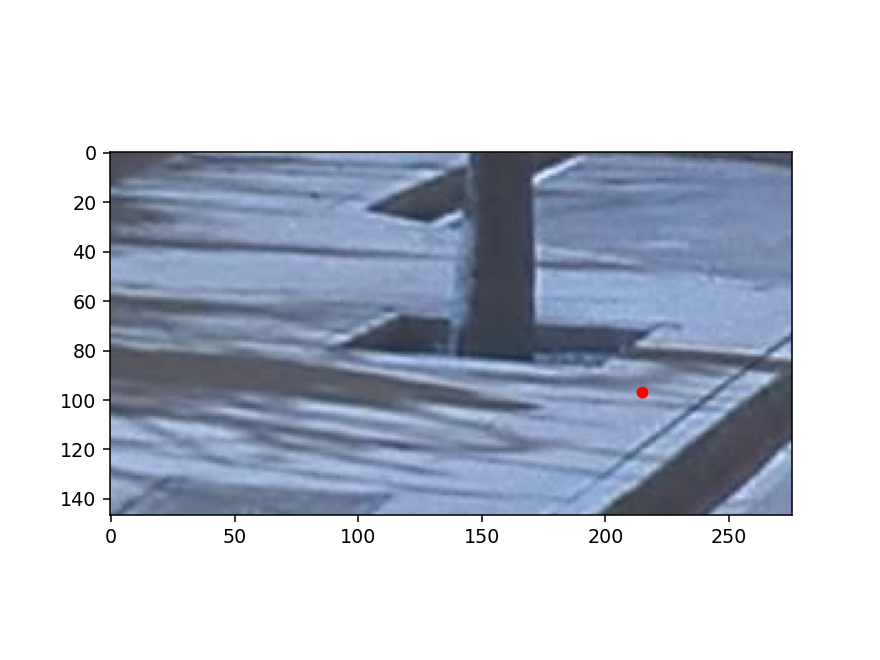

In [220]:
from matplotlib.patches import Circle,Rectangle,Polygon
%matplotlib notebook
fig,ax=plt.subplots(1)
ax.imshow(image)
ax.add_patch(Circle((col,row),2,color='red'))